In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns #;sns.set(); sns.set_context('paper')
import os
from qbstyles import mpl_style
from scipy import stats

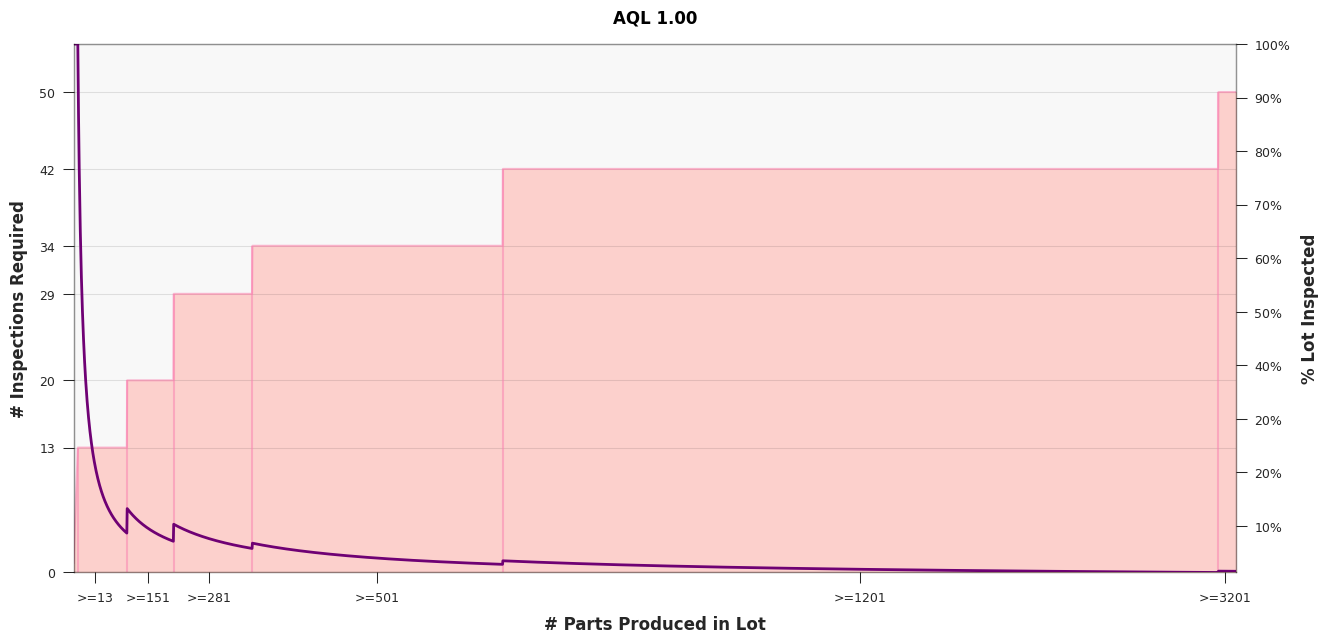

In [2]:
mpl_style(dark=False)


def get_inspections(x):
    switcher = {
        range(0,14): x['Qty'],
        range(14,151): 13,
        range(151,281): 20,
        range(281,501): 29,
        range(501,1201): 34,
        range(1201,3201): 42,
        range(3201,3300): 50
    }
    for key in switcher.keys():
        if x['Qty'] in key:
            x['AQL'] = switcher[key]
    return x

a = np.arange(1,3251)
b = np.zeros(3250, dtype=np.int)
aql_frame = pd.DataFrame({'Qty': pd.Series(a),
                        'AQL': pd.Series(b)})
aql_frame = aql_frame.apply(get_inspections, axis=1)
aql_frame['%'] = aql_frame['AQL'] / aql_frame['Qty']

# Grab a subset for creating vertical lines
aql_frame_gb = aql_frame
aql_frame_gb = aql_frame_gb.groupby('AQL').agg({'Qty':np.min})
vlines = aql_frame_gb[-6:].to_dict()['Qty']

# Get Colors Formatting colors
col = mpl.cm.get_cmap('RdPu')
# Plotting
fig,ax = plt.subplots(figsize=(15,7), dpi=100)
ax.plot(aql_frame['Qty'], aql_frame['AQL'], c='#fa7fb0', alpha=0.5)
ax.fill_between(x=aql_frame['Qty'],y1=0, y2=aql_frame['AQL'],color=mpl.colors.to_hex(col(0.2)))   # color='#9448bc')
ax2 = ax.twinx()
ax2.plot(aql_frame['Qty'], aql_frame['%'], c=mpl.colors.to_hex(col(0.9)), lw=2.0)
for ymax in vlines:
    ax.vlines(x=vlines[ymax], ymin=0, ymax=ymax, ls='solid', color='#fa7fb0', alpha=0.5)

# Decorators
plt.title('AQL 1.00', fontdict={'fontweight':'bold'})
ax.set_ylabel('# Inspections Required', fontdict={'fontweight':'bold'})
ax.set_xlabel('# Parts Produced in Lot',  fontdict={'fontweight':'bold'})
ax2.set_ylabel('% Lot Inspected', fontdict={'fontweight':'bold'})
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.yaxis.set_minor_locator(plt.NullLocator())
ax2.set_yticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0])
ax2.set_yticklabels(['0%','10%','20%','20%','40%','50%','60%','70%','80%','90%','100%'])

ax.set_xticks([60,210,380,850,2200,3220])
ax.set_xticklabels(['>=13','>=151','>=281','>=501','>=1201','>=3201'])
ax.set_yticks([0,13,20,29,34,42,50])
ax.set_xmargin(0)
ax.set_ymargin(0)
ax2.set_ymargin(0)
ax.set_ylim(ymin=0, ymax=55)
ax.grid(b=True, alpha=0.1, linestyle='-', markersize='5.0')
ax.grid(b=False, axis='x')
ax2.grid(b=False)


In [3]:
# Read Sales Order Data

so_df = pd.DataFrame()

for so in ['3492','3497','3500','3555','3561','3563','3574','3582']:
    temp_df = pd.read_csv(filepath_or_buffer=os.getcwd().replace("notebooks","csv\\") + so + ".csv", header=0, index_col=False)
    so_df = pd.concat([so_df,temp_df], ignore_index=True)
    
so_df['SO_Number'] = so_df['JobNum'].str[0:4]
so_df

,JobNum,LotNum,DrawNum,PartDescription,TranQty,QtyCompleted,PhaseID,OrigProdQty,AQLAmount,AQLforTranQty,SO_Number
0,3492-01-1,NV10200,1541900,5.5 Poly Tulip 5.5 Ti,27.0,549.0,Tulip,500.0,29.0,1.426230,3492
1,3492-01-1,NV10458,1541901,5.5mm Load Ring Ti,27.0,550.0,Load Ring,500.0,29.0,1.423636,3492
2,3492-01-1,NV14430,1567720,6.5 x 50mm Fenestrated Shank,27.0,83.0,Shank,25.0,13.0,4.228916,3492
3,3492-01-1,NV14629,1541902,"Deformity Poly Split Ring, Ti",27.0,604.0,Clip/Split Ring,500.0,29.0,1.296358,3492
4,3492-02-1,NV10937,1553262,5.5mm Precept Polyaxial Tulip,220.0,550.0,Tulip,500.0,29.0,11.600000,3492
...,...,...,...,...,...,...,...,...,...,...,...
685,3582-15-1,NV15297,1590480,7.5 x 50mm Precept Screw Shank,139.0,219.0,Shank,180.0,20.0,12.694064,3582
686,3582-16-1,NV14649,1582023,Precept Poly C.R. Load Ring,52.0,550.0,Load Ring,500.0,29.0,2.741818,3582
687,3582-16-1,NV14657,1582022,Precept Poly Clip Ring,52.0,1637.0,Clip/Split Ring,1000.0,34.0,1.080024,3582
688,3582-16-1,NV14670,1582025,Precept Poly C.R. Tulip,52.0,650.0,Tulip,500.0,29.0,2.320000,3582


In [39]:
# Find the Mode of our OrigProdQty's by PhaseID

modes = {}
for label in ['Tulip','Load Ring','Shank']:
    phase_df = so_df[so_df['PhaseID'].str.contains(label)].sort_values('OrigProdQty', axis=0, ascending=True)
    phase_df1, phase_df2 = np.split(phase_df['OrigProdQty'],2,axis=0)
    phase_mode1, phase_mode2 = stats.mode(phase_df1), stats.mode(phase_df2)
    modes.update({label:[phase_mode1[0][0], phase_mode2[0][0]]})

for label in ['Clip/Split Ring','Extension']:
    phase_df = so_df[so_df['PhaseID'].str.contains(label)]
    phase_mode = stats.mode(phase_df['OrigProdQty'])
    modes.update({label:phase_mode[0][0]})

modes

{'Tulip': [250.0, 500.0],
 'Load Ring': [500.0, 1000.0],
 'Shank': [25.0, 250.0],
 'Clip/Split Ring': 1000.0,
 'Extension': 250.0}

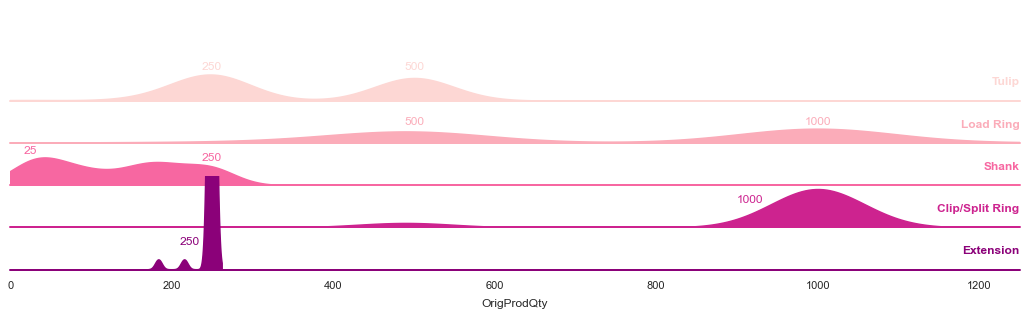

In [78]:

orig_df = so_df[['OrigProdQty', 'PhaseID']]
sns.set()
plt.rc('axes', facecolor=(0,0,0,0))
position={'Tulip':[.005,.005],'Load Ring':[.003,.003],'Shank':[.005,.004],'Clip/Split Ring':900,'Extension':210}


def label(x, color, label):
    ax = plt.gca()    
    ax.text(1.0, .2, label, fontweight="bold", color=color,
            ha="right", va="center", transform=ax.transAxes)
    vals = modes[label]
    if isinstance(vals,list):
        for pos,mode in enumerate(vals):
            # Can we put a condition in the fontweight to bold if it is 25?
            ax.text(mode, position[label][pos], int(mode), color=color, ha='center')
    else:
        ax.text(position[label], .004, int(vals), color=color)

# TODO: grab colors from the darker side of our plot to cycle through
g = sns.FacetGrid(orig_df, row='PhaseID', hue='PhaseID', palette='RdPu', height=2.5, aspect=6, xlim=(0,1250), ylim=(0,.015))
g.map(sns.kdeplot, 'OrigProdQty', fill=True, linewidth=1.5, alpha=1.0, bw_adjust=1.0)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.set_xlabels(label='')
g.map(label, "OrigProdQty")
g.set_titles('')
g.set(yticks=[])
g.fig.subplots_adjust(hspace=-.55, top=0.35)
g.despine(bottom=True, left=True)
for ax in g.axes.flat:
    ax.grid(b=False)
    ax.margins(x=0)



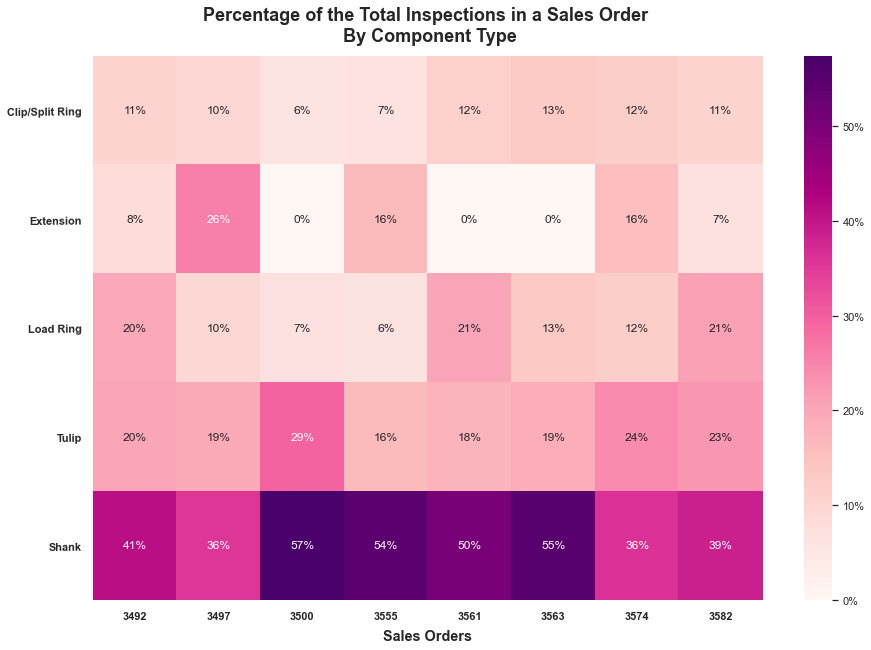

In [6]:
sns.set()

pivot_df = so_df.pivot_table(values='AQLforTranQty',index='PhaseID',columns='SO_Number',aggfunc=np.sum, fill_value=0)
pivot_df = pivot_df.reindex(['Clip/Split Ring','Extension','Load Ring','Tulip','Shank'],)

# Normalize values as a percentage of the total for that order
pivot_df = pivot_df.apply(func=lambda x: x/x.sum(), axis=0)

# Plot the Data
fig,ax = plt.subplots(figsize=(15,10))
plt.title("Percentage of the Total Inspections in a Sales Order \n By Component Type",{'fontsize':18, 'fontweight':'bold'})
ax = sns.heatmap(pivot_df,cmap='RdPu', ax=ax,annot=True,fmt='2.0%', annot_kws={'fontsize':'medium'}, cbar_kws={'format':'%0.f%%'})

# Decorators
cbar = fig.get_axes()[1]
cbar.set_yticklabels(['0%','10%','20%','30%','40%','50%'])
ax.set_ylabel('')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontdict={'fontweight':'bold'})
ax.set_xticklabels(labels=ax.get_xticklabels(), fontdict={'fontweight':'bold'})
ax.set_xlabel('Sales Orders',{'fontweight':'bold', 'fontsize':'large'})
ax.tick_params(axis='y', labelrotation=.5)



In [7]:
so_3497 = so_df[so_df['JobNum'].str.contains('3497')]

so_3497.groupby(by='PhaseID').aggregate({'AQLforTranQty':np.sum})

,AQLforTranQty
PhaseID,
Clip/Split Ring,66.577514
Extension,175.638141
Load Ring,66.203137
Shank,243.590407
Tulip,133.439420


## 3497 Testing

In [8]:
# os.getcwd().replace("notebooks","csv\\")
df3497 = pd.read_csv(filepath_or_buffer=os.getcwd().replace("notebooks","csv\\") + "3497.csv", header=0, index_col=False)
df3497

,JobNum,LotNum,DrawNum,PartDescription,TranQty,QtyCompleted,PhaseID,OrigProdQty,AQLAmount,AQLforTranQty
0,3497-01-2,NV13007,1751200,5.5 x 50mm Cannulated Cancellous Shank,40.0,68.0,Shank,25.0,13.0,7.647059
1,3497-01-2,NV13687,1642646,Reline Breakoff Extension,40.0,275.0,Extension,250.0,20.0,2.909091
2,3497-01-2,NV13727,1642652,Reline MAS Reduction Tulip Base,40.0,274.0,Tulip,250.0,20.0,2.919708
3,3497-01-2,NV14174,1642661,Reline Poly Load Ring,40.0,1100.0,Load Ring,1000.0,34.0,1.236364
4,3497-01-2,NV14394,1642666,Reline Clip Ring Flat,44.0,1100.0,Clip/Split Ring,1000.0,34.0,1.360000
...,...,...,...,...,...,...,...,...,...,...
105,3497-16-1,NV13786,1642666,Reline Clip Ring Flat,28.0,1045.0,Clip/Split Ring,1000.0,34.0,0.911005
106,3497-16-1,NV13866,1642646,Reline Breakoff Extension,28.0,275.0,Extension,250.0,20.0,2.036364
107,3497-16-1,NV13868,1642652,Reline MAS Reduction Tulip Base,28.0,275.0,Tulip,250.0,20.0,2.036364
108,3497-16-1,NV14391,1642661,Reline Poly Load Ring,28.0,1100.0,Load Ring,1000.0,34.0,0.865455


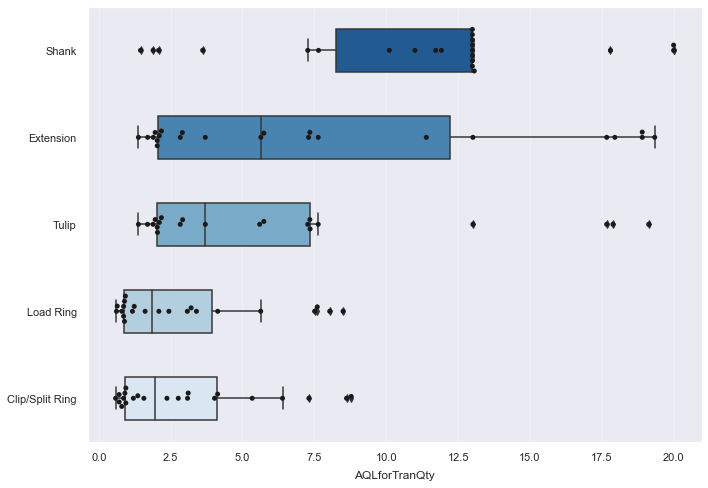

In [9]:
fig,ax = plt.subplots(figsize=(11,8))
ax.yaxis.label.set_visible(False)
ax = sns.boxplot(x='AQLforTranQty',y='PhaseID', data=df3497, ax=ax, palette='Blues_r', width=.5, whis=.75)
ax = sns.swarmplot(x='AQLforTranQty',y='PhaseID', data=df3497, ax=ax, color='k')

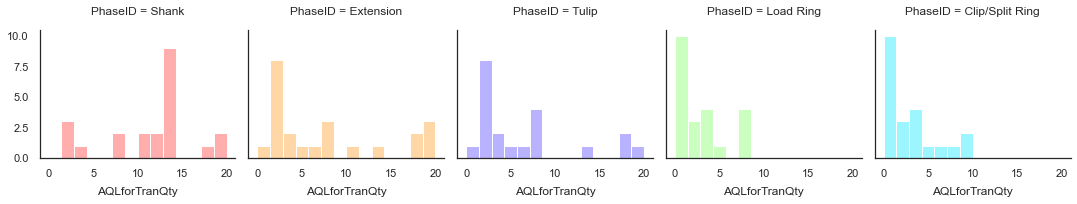

In [10]:
with sns.axes_style(style='white'):
    grid = sns.FacetGrid(df3497, col='PhaseID',sharey=True, hue='PhaseID', palette=['#FFADAD','#FFD6A5','#B8B2FF','#CAFFBF','#9BF6FF'])
    grid.map(plt.hist, 'AQLforTranQty', bins=np.linspace(0,20,15))
    

In [11]:
df3497_sorted = df3497.sort_values(by=['PhaseID','AQLforTranQty'],axis=0,ascending=True)



<AxesSubplot:ylabel='AQLforTranQty'>

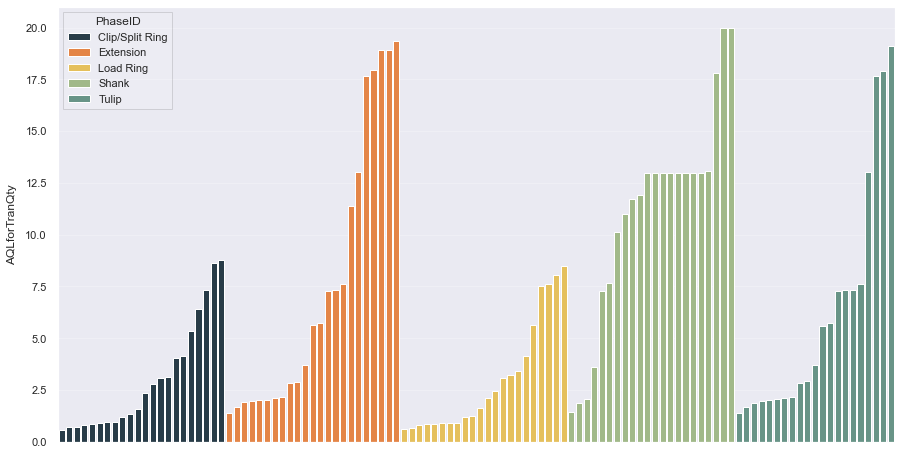

In [12]:

fig, ax = plt.subplots(figsize=(15,8))
# ax.set_facecolor('white')
ax.set_xticklabels(labels=[],visible=False)
sns.barplot(x=np.arange(0,110,1),y='AQLforTranQty', data=df3497_sorted, hue='PhaseID', 
            palette=['#233D4D','#FE7F2D','#FCCA46','#A1C181','#619B8A'], ax=ax, dodge=False)

In [13]:
# df3574 = pd.read_csv(filepath_or_buffer=os.getcwd().replace('notebooks', 'csv\\3574.csv'),header=0, index_col=None)

df3497.groupby(by='PhaseID').aggregate({'AQLforTranQty':np.sum})

,AQLforTranQty
PhaseID,
Clip/Split Ring,66.577514
Extension,175.638141
Load Ring,66.203137
Shank,243.590407
Tulip,133.439420
